<a href="https://colab.research.google.com/github/sayyed-uoft/fullstackai/blob/main/13_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strata.ai - Artificial Intelligence Certificate 

# Module 3: Practical Deep Learning

# Training Deep Neural Networks
**Text Book:** Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow, Second Edition, Aurélien Géron

Source: https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb

# Setup

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Training Deep Neural Networks

So far, we used and trained very shallow neureal networks with just a few hidden layers. However, sometime we need to tackle a very complex problem, such as detecting hundreds of types of objects in high-resolution images. Consequently, we may need to train a much deeper DNN, perhaps with 10 layers or much more, each containing hundreds of neurons, connected by hundreds of thousands of connections. This would not be easy and you will face some challenges that we will discuss in this section.

# Vanishing/Exploding Gradients Problem

As discussed before, the backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step. When the number of layers is high, one of the following challenges may occur:

- **Vanising Gradients**: gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution.
- **Exploding Gradients**: the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges.



The researchers has found that the problem is the  combination of teh activation function and weight initialization methods. For example, one <a href="http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf" targetr="_blank">paper</a> showed that with the sigmoid activation function and random initialization of the wights using a standard normal distribution, the variance of the outputs of each layer is much greater than the variance of its inputs. Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. Let's look at the sigmoid activation function:

In [4]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


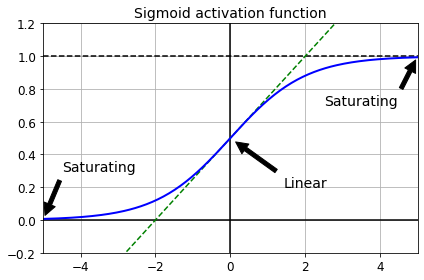

In [5]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Initialization Methods

The previously mwntioned paper suggested a new initialization method called **Glorot** (that last name of the paper's author) for the sigmoid function.

Other researchers suggested other initilization methods for other activation functions. Below is the best initialization methods for each activation function:

|Initialization|Activation Functions| 
|-----|-------| 
|Glorot|None, Tanh, Logistic, Softmax| 
|He|ReLU & variants|
|LeCun|SELU|

Here is the list of initialization methods supported by Keras:

In [6]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

By default, Keras uses Glorot initialization with a uniform distribution. You can change this to He initialization by setting kernel_initializer="he_uniform" or ker nel_initializer="he_normal" when creating a layer, like this:

In [7]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

## Nonsaturating Activation Functions

So far we learned that ReLU activation function works well for the hidden layer of the deep neural networks. However, the ReLU activation function is not perfect. It suffers from a problem known as the **dying ReLUs**: during training, some neurons effectively die, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. A neu‐ ron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting 0s, and gradient descent does not affect it anymore since the gradient of the ReLU function is 0 when its input is negative.

One way to solve the above problem, you may want to use a variant of the ReLU function, such as the **leaky ReLU**.

$$LeakyReLU_\alpha(z) = max(\alpha z, z)$$

The hyperparameter $\alpha$ defines how much the function “leaks”. It is shown $\alpha = 0.2$ is a good value most of the times.

### Leaky ReLU

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


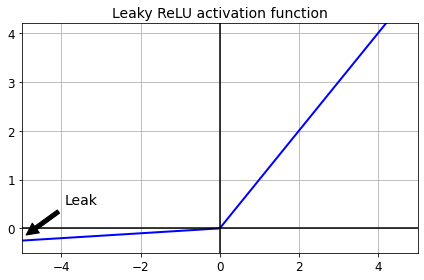

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Let's look at activation functions supported by Keras:

In [10]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

Let's looka ad ReLU layers in Keras:

In [11]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

There are other variations. How do we select which one to use?

To use the leaky ReLU activation function, you must create a LeakyReLU instance like this:

In [12]:
leaky_relu = keras.layers.LeakyReLU(alpha=0.2)
layer = keras.layers.Dense(10, activation=leaky_relu,
kernel_initializer="he_normal")

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [13]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4423680/4422102 [==============================] - 0s 0us/step


In [14]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5339 - accuracy: 0.8223 - val_loss: 0.5156 - val_accuracy:

Now let's try Parametric leaky ReLU (PReLU), where $\alpha$ is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter):

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5390 - accuracy: 0.8206 - val_loss: 0.5196 - val_accuracy:

### ELU

Another <a href="https://arxiv.org/abs/1511.07289" target="_blank">paper</a> has proposed a new activation function called **the exponential linear unit (ELU)** that outperformed all the ReLU variants in their experiments: training time was reduced and the neural network performed better on the test set.

$$ELU_\alpha(z) = \left\{\begin{matrix} \alpha(exp(z)-1) & z \lt 0\\ z & z \ge 0 \end{matrix}\right.$$

The main drawback of the ELU activation function is that it is slower to compute than the ReLU and its variants (due to the use of the exponential function), but during training this is compensated by the faster convergence rate. However, at test time an ELU network will be slower than a ReLU network.

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


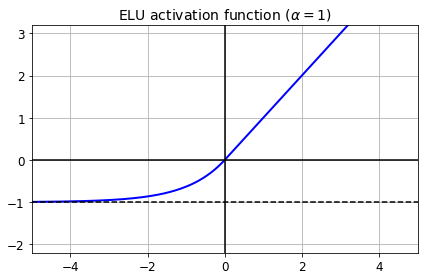

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [21]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [24]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


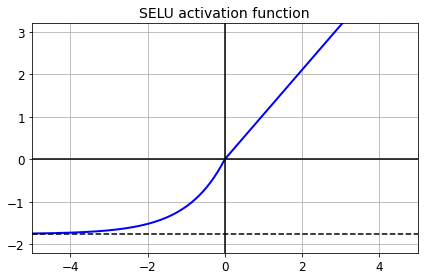

In [25]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [26]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [27]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [32]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [33]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 33s 17ms/step - loss: 1.3776 - accuracy: 0.4540 - val_loss: 1.1731 - val_accuracy: 0.5614
Epoch 2/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.9138 - accuracy: 0.6665 - val_loss: 0.7028 - val_accuracy: 0.7484
Epoch 3/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6962 - accuracy: 0.7481 - val_loss: 0.6540 - val_accuracy: 0.7546
Epoch 4/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6539 - accuracy: 0.7676 - val_loss: 0.5557 - val_accuracy: 0.7978
Epoch 5/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.5582 - accuracy: 0.7990 - val_loss: 0.5703 - val_accuracy: 0.8016


Now look at what happens if we try to use the ReLU activation function instead:

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [38]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 16ms/step - loss: 1.8261 - accuracy: 0.2616 - val_loss: 1.3347 - val_accuracy: 0.3894
Epoch 2/5
1719/1719 [==============================] - 27s 16ms/step - loss: 1.1959 - accuracy: 0.4908 - val_loss: 0.9373 - val_accuracy: 0.5902
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.9600 - accuracy: 0.6118 - val_loss: 0.9026 - val_accuracy: 0.5906
Epoch 4/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.8231 - accuracy: 0.6759 - val_loss: 0.7320 - val_accuracy: 0.7290
Epoch 5/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.7360 - accuracy: 0.7171 - val_loss: 0.7823 - val_accuracy: 0.7108


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of train‐ ing, it doesn’t guarantee that they won’t come back during training.

Another [paper](https://arxiv.org/abs/1502.03167) has proposed a technique called **Batch Normalization (BN)** to address the vanishing/exploding gradients problems.

The technique consists of adding an operation in the model just before or after the activation function of each hidden layer, simply zero-centering and normalizing each input, then scaling and shifting the result using two new parameter vectors per layer for: 
1. scaling, 
1. shifting. 

This operation lets the model learn the optimal scale and mean of each of the layer’s inputs. 

In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g., using a StandardScaler): the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. It does so by evaluating the mean and stan‐ dard deviation of each input over the current mini-batch (hence the name “Batch Normalization”).

Batch Normalization does, however, add some complexity to the model (although it can remove the need for normalizing the input data, as we discussed earlier). Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. So if you need predictions to be lightning-fast, you may want to check how well plain ELU + He initialization perform before playing with Batch Normalization.

It is demonstrated that this technique considerably improved all the deep neural networks they experimented with, leading to a huge improvement in the ImageNet classification task (ImageNet is a large database of images classified into many classes and commonly used to evaluate computer vision systems). The vanishing gradients problem was strongly reduced, to the point that they could use saturat‐ ing activation functions such as the tanh and even the logistic activation function. The networks were also much less sensitive to the weight initialization. They were able to use much larger learning rates, significantly speeding up the learning process. Specifically, they note that “Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. 

As with most things with Keras, implementing Batch Normalization is quite simple. Just add a BatchNormalization layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model.

In [39]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

In [41]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [44]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8750 - accuracy: 0.7124 - val_loss: 0.5525 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5753 - accuracy: 0.8031 - val_loss: 0.4725 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5190 - accuracy: 0.8204 - val_loss: 0.4375 - val_accuracy: 0.8548
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4827 - accuracy: 0.8324 - val_loss: 0.4152 - val_accuracy: 0.8596
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4566 - accuracy: 0.8410 - val_loss: 0.3997 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4398 - accuracy: 0.8475 - val_loss: 0.3867 - val_accuracy: 0.8694
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4242 - accuracy: 0.8514 - val_loss: 0.3764 - val_accuracy

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 1.3677 - accuracy: 0.5604 - val_loss: 0.6767 - val_accuracy: 0.7812
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7136 - accuracy: 0.7702 - val_loss: 0.5566 - val_accuracy: 0.8184
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6123 - accuracy: 0.7990 - val_loss: 0.5007 - val_accuracy: 0.8360
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5547 - accuracy: 0.8148 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5255 - accuracy: 0.8230 - val_loss: 0.4434 - val_accuracy: 0.8534
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4947 - accuracy: 0.8328 - val_loss: 0.4263 - val_accuracy: 0.8550
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4736 - accuracy: 0.8385 - val_loss: 0.4130 - val_accuracy:

## Gradient Clipping

Another popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold. This technique is most often used in recurrent neural networks, as Batch Normalization is tricky to use in RNNs. For other types of networks, BN is usually sufficient.

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [45]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

This will clip every component of the gradient vector to a value between –1.0 and 1.0.

If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue.

In [46]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network: this is called **transfer learning**. It will not only speed up training considerably, but will also require much less training data.

A common example is using pre-trained ImageNet models. 

<img src="https://github.com/sayyed-uoft/fullstackai/raw/main/transfer_learning.png" width="80%"/>

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.


### Reusing a Keras model

Let’s look at an example. Suppose the fashion MNIST dataset only contained 8 classes, for example all classes except for sandals and shirts. Someone built and trained a Keras model on that set and got reasonably good performance (>90% accuracy). Let’s call this model A. You now want to tackle a different task: you have images of sandals and shirts, and you want to train a binary classifier (positive=shirts, negative=san‐ dals). However, your dataset is quite small, you only have 200 labeled images. When you train a new model for this task (let’s call it model B), with the same architecture as model A, it performs reasonably well (97.2% accuracy), but since it’s a much easier task (there are just 2 classes), you were hoping for more.

This can be done with Transfer Learning.

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [47]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [48]:
X_train_A.shape

(43986, 28, 28)

In [49]:
X_train_B.shape

(200, 28, 28)

In [50]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [51]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [52]:
tf.random.set_seed(42)
np.random.seed(42)

In [54]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [55]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [56]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5803 - accuracy: 0.8143 - val_loss: 0.3851 - val_accuracy: 0.8677
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3580 - accuracy: 0.8774 - val_loss: 0.3227 - val_accuracy: 0.8916
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3210 - accuracy: 0.8899 - val_loss: 0.2995 - val_accuracy: 0.8994
Epoch 4/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3016 - accuracy: 0.8969 - val_loss: 0.2868 - val_accuracy: 0.9036
Epoch 5/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2882 - accuracy: 0.9017 - val_loss: 0.2767 - val_accuracy: 0.9071
Epoch 6/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2780 - accuracy: 0.9039 - val_loss: 0.2716 - val_accuracy: 0.9108
Epoch 7/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2697 - accuracy: 0.9077 - val_loss: 0.2708 - val_accuracy:

In [57]:
model_A.save("my_model_A.h5")

Let's train the model B from scratch (same architecture):

In [58]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [60]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [61]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 39ms/step - loss: 0.5486 - accuracy: 0.7300 - val_loss: 0.4821 - val_accuracy: 0.8012
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 0.3941 - accuracy: 0.8550 - val_loss: 0.3780 - val_accuracy: 0.8682
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3016 - accuracy: 0.9150 - val_loss: 0.3135 - val_accuracy: 0.9087
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.2448 - accuracy: 0.9600 - val_loss: 0.2684 - val_accuracy: 0.9260
Epoch 5/20
7/7 [==============================] - 0s 13ms/step - loss: 0.2043 - accuracy: 0.9750 - val_loss: 0.2376 - val_accuracy: 0.9391
Epoch 6/20
7/7 [==============================] - 0s 13ms/step - loss: 0.1761 - accuracy: 0.9800 - val_loss: 0.2146 - val_accuracy: 0.9483
Epoch 7/20
7/7 [==============================] - 0s 18ms/step - loss: 0.1553 - accuracy: 0.9800 - val_loss: 0.1972 - val_accuracy: 0.9533
Epoch 8/20
7/7 [===========

In [62]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_227 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_228 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_229 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_230 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_231 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_232 (Dense)            (None, 1)                

Now, let's use transfer learning.

First, you need to load model A, and create a new model based on the model A’s layers. Let’s reuse all layers except for the output layer:

In [71]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that model_A and model_B_on_A now share some layers. When you train model_B_on_A, it will also affect model_A. If you want to avoid that, you need to clone model_A before you reuse its layers. To do this, you must clone model A’s architecture, then copy its weights (since clone_model() does not clone the weights):

In [72]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Now we could just train model_B_on_A for task B, but since the new output layer was initialized randomly, it will make large errors, at least during the first few epochs, so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, simply set every layer’s train able attribute to False and compile the model.

Next, we can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights:

In [73]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 93ms/step - loss: 0.4283 - accuracy: 0.7900 - val_loss: 0.4269 - val_accuracy: 0.8063
Epoch 2/4
7/7 [==============================] - 0s 14ms/step - loss: 0.4070 - accuracy: 0.8000 - val_loss: 0.4059 - val_accuracy: 0.8164
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 0.3856 - accuracy: 0.8050 - val_loss: 0.3870 - val_accuracy: 0.8215
Epoch 4/4
7/7 [==============================] - 0s 13ms/step - loss: 0.3664 - accuracy: 0.8150 - val_loss: 0.3689 - val_accuracy: 0.8306


In [74]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 [==============================] - 1s 41ms/step - loss: 0.3142 - accuracy: 0.8400 - val_loss: 0.2732 - val_accuracy: 0.8783
Epoch 2/16
7/7 [==============================] - 0s 15ms/step - loss: 0.2312 - accuracy: 0.8900 - val_loss: 0.2114 - val_accuracy: 0.9158
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.1772 - accuracy: 0.9400 - val_loss: 0.1732 - val_accuracy: 0.9422
Epoch 4/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1437 - accuracy: 0.9750 - val_loss: 0.1463 - val_accuracy: 0.9635
Epoch 5/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1194 - accuracy: 0.9900 - val_loss: 0.1271 - val_accuracy: 0.9736
Epoch 6/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1020 - accuracy: 0.9950 - val_loss: 0.1124 - val_accuracy: 0.9828
Epoch 7/16
7/7 [==============================] - 0s 16ms/step - loss: 0.0887 - accuracy: 0.9950 - val_loss: 0.1016 - val_accuracy: 0.9848
Epoch 8/16
7/7 [===========

So, what's the final verdict?

In [75]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0931 - accuracy: 0.9835


[0.09306484460830688, 0.9835000038146973]

In [76]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0588 - accuracy: 0.9960


[0.05882209539413452, 0.9959999918937683]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4.5!

In [70]:
(100 - 97.05) / (100 - 99.35)

4.538461538461503

# Faster Optimizers

## Momentum optimization

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [ ]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

## RMSProp

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

## Adam Optimization

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [ ]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [ ]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5980 - accuracy: 0.7933 - val_loss: 0.4031 - val_accuracy: 0.8598
Epoch 2/25
1719/1719 [==============================] - 2s 954us/step - loss: 0.3829 - accuracy: 0.8636 - val_loss: 0.3714 - val_accuracy: 0.8720
Epoch 3/25
1719/1719 [==============================] - 2s 943us/step - loss: 0.3491 - accuracy: 0.8771 - val_loss: 0.3746 - val_accuracy: 0.8738
Epoch 4/25
1719/1719 [==============================] - 2s 954us/step - loss: 0.3277 - accuracy: 0.8814 - val_loss: 0.3502 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 2s 934us/step - loss: 0.3172 - accuracy: 0.8856 - val_loss: 0.3453 - val_accuracy: 0.8780
Epoch 6/25
1719/1719 [==============================] - 2s 919us/step - loss: 0.2922 - accuracy: 0.8940 - val_loss: 0.3419 - val_accuracy: 0.8820
Epoch 7/25
1719/1719 [==============================] - 2s 921us/step - loss: 0.2870 - accuracy: 0.8973 - val_loss: 0.3362 - v

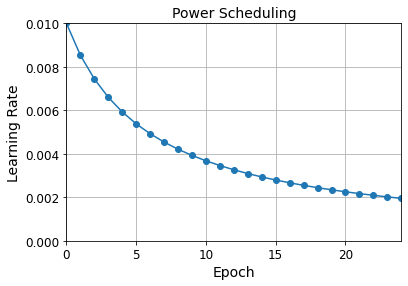

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 1.1122 - accuracy: 0.7363 - val_loss: 0.8947 - val_accuracy: 0.7496
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7354 - accuracy: 0.7825 - val_loss: 0.6059 - val_accuracy: 0.8122
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5973 - accuracy: 0.8175 - val_loss: 0.8195 - val_accuracy: 0.7754
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6040 - accuracy: 0.8148 - val_loss: 0.6135 - val_accuracy: 0.8398
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5462 - accuracy: 0.8323 - val_loss: 0.5075 - val_accuracy: 0.8490
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4479 - accuracy: 0.8555 - val_loss: 0.4538 - val_accuracy: 0.8502
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4225 - accuracy: 0.8622 - val_loss: 0.4792 - val_accuracy:

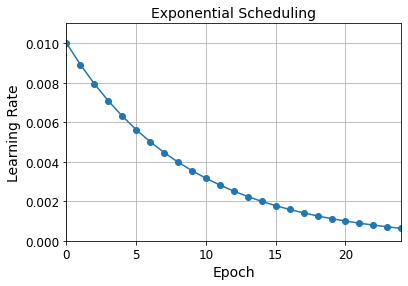

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.1153 - accuracy: 0.7390 - val_loss: 0.9588 - val_accuracy: 0.7338
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6929 - accuracy: 0.7934 - val_loss: 0.5328 - val_accuracy: 0.8318
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6317 - accuracy: 0.8097 - val_loss: 0.7656 - val_accuracy: 0.8278
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5827 - accuracy: 0.8258 - val_loss: 0.5585 - val_accuracy: 0.8382
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5041 - accuracy: 0.8407 - val_loss: 0.5367 - val_accuracy: 0.8574
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4595 - accuracy: 0.8588 - val_loss: 0.6000 - val_accuracy: 0.8516
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4490 - accuracy: 0.8644 - val_loss: 0.4605 - val_accuracy:

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

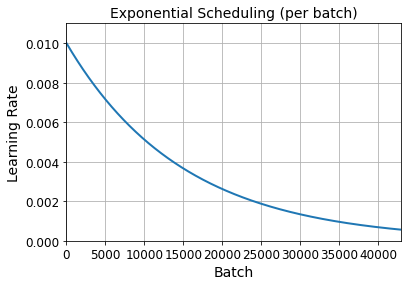

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 1.1511 - accuracy: 0.7326 - val_loss: 0.8456 - val_accuracy: 0.7410
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7371 - accuracy: 0.7786 - val_loss: 0.6796 - val_accuracy: 0.8092
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8055 - accuracy: 0.7700 - val_loss: 1.7429 - val_accuracy: 0.4514
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 1.0351 - accuracy: 0.6826 - val_loss: 0.9870 - val_accuracy: 0.6928
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.9185 - accuracy: 0.7098 - val_loss: 0.8727 - val_accuracy: 0.6932
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6905 - accuracy: 0.7481 - val_loss: 0.6694 - val_accuracy: 0.7696
Epoch 7/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6115 - accuracy: 0.7713 - val_loss: 0.6956 - val_accuracy:

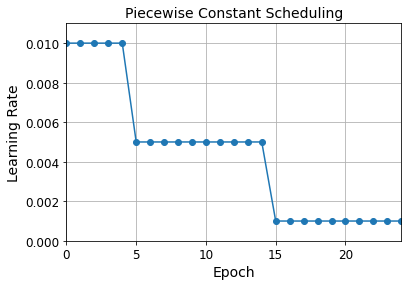

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7116 - accuracy: 0.7769 - val_loss: 0.4869 - val_accuracy: 0.8478
Epoch 2/25
1719/1719 [==============================] - 2s 947us/step - loss: 0.4912 - accuracy: 0.8390 - val_loss: 0.5958 - val_accuracy: 0.8270
Epoch 3/25
1719/1719 [==============================] - 2s 987us/step - loss: 0.5222 - accuracy: 0.8379 - val_loss: 0.4869 - val_accuracy: 0.8584
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5061 - accuracy: 0.8467 - val_loss: 0.4588 - val_accuracy: 0.8548
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5216 - accuracy: 0.8469 - val_loss: 0.6096 - val_accuracy: 0.8300
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4984 - accuracy: 0.8546 - val_loss: 0.5359 - val_accuracy: 0.8498
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5104 - accuracy: 0.8579 - val_loss: 0.5457 - val_accur

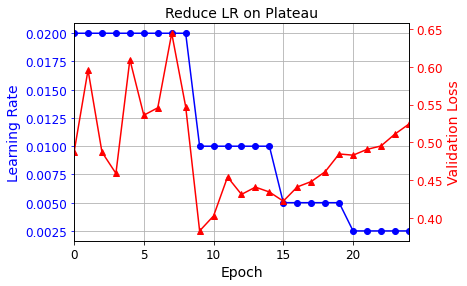

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5995 - accuracy: 0.7923 - val_loss: 0.4095 - val_accuracy: 0.8606
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3890 - accuracy: 0.8613 - val_loss: 0.3738 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3530 - accuracy: 0.8772 - val_loss: 0.3735 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3296 - accuracy: 0.8813 - val_loss: 0.3494 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3178 - accuracy: 0.8867 - val_loss: 0.3430 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2930 - accuracy: 0.8951 - val_loss: 0.3414 - val_accuracy: 0.8826
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2854 - accuracy: 0.8985 - val_loss: 0.3354 - val_accuracy:

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
```

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3120


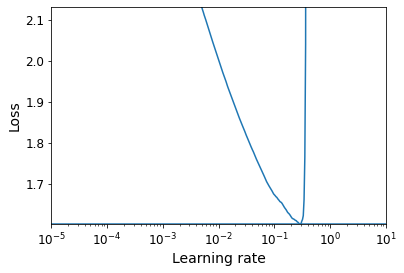

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 2ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8338
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4580 - accuracy: 0.8397 - val_loss: 0.4274 - val_accuracy: 0.8520
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.8545 - val_loss: 0.4116 - val_accuracy: 0.8588
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3837 - accuracy: 0.8642 - val_loss: 0.3868 - val_accuracy: 0.8688
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3639 - accuracy: 0.8719 - val_loss: 0.3766 - val_accuracy: 0.8688
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3456 - accuracy: 0.8775 - val_loss: 0.3739 - val_accuracy: 0.8706
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3635 - val_accuracy: 0.8708
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.2189 - accuracy: 0.7967 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7280 - accuracy: 0.8247 - val_loss: 0.6850 - val_accuracy: 0.8376


In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 3.2911 - accuracy: 0.7924 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7282 - accuracy: 0.8245 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7611 - accuracy: 0.7576 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4306 - accuracy: 0.8401 - val_loss: 0.3395 - val_accuracy: 0.8722


## Alpha Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8023 - accuracy: 0.7146 - val_loss: 0.5781 - val_accuracy: 0.8442
Epoch 2/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5663 - accuracy: 0.7905 - val_loss: 0.5182 - val_accuracy: 0.8520
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5264 - accuracy: 0.8054 - val_loss: 0.4874 - val_accuracy: 0.8600
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5126 - accuracy: 0.8092 - val_loss: 0.4890 - val_accuracy: 0.8598
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5071 - accuracy: 0.8133 - val_loss: 0.4266 - val_accuracy: 0.8696
Epoch 6/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4793 - accuracy: 0.8198 - val_loss: 0.4585 - val_accuracy: 0.8640
Epoch 7/20
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4724 - accuracy: 0.8262 - val_loss: 0.4740 - val_accuracy:

In [ ]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 834us/step - loss: 0.4723 - accuracy: 0.8639


[0.47229740023612976, 0.8639000058174133]

In [ ]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 1s 782us/step - loss: 0.3501 - accuracy: 0.8840


[0.3501231074333191, 0.8840363621711731]

In [ ]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.4225 - accuracy: 0.8432


## MC Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],
      dtype=float32)

In [ ]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.57, 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.93, 0.  , 0.05]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.46, 0.  , 0.53]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.24]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.43, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.28, 0.  , 0.59]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.06, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.07, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.28, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.29, 0.  , 0.7 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.22, 0.  , 0

In [ ]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.22, 0.  , 0.68]],
      dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.24, 0.  , 0.29]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8661

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.25, 0.01, 0.61]],
      dtype=float32)

## Max norm

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5763 - accuracy: 0.8020 - val_loss: 0.3674 - val_accuracy: 0.8674
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3545 - accuracy: 0.8709 - val_loss: 0.3714 - val_accuracy: 0.8662
